# Tasks

Based on the task description provided, here's a structured step-by-step plan to complete your sentiment analysis mini-challenge. Each step is tailored to ensure compatibility with the challenge requirements and provided data.

---

### **Step 1: Setup and Dataset Selection**
1. **Select Dataset**:
   - Use one of the recommended datasets such as `sst2`, `amazon_polarity`, or `financial_phrasebank`.
   - Download the dataset using Hugging Face's `datasets` library.

2. **Environment Setup**:
   - Install required libraries: `transformers`, `datasets`, `scikit-learn`, `matplotlib`, `seaborn`, and `pandas`.
   - Set up `requirements.txt` or `environment.yml` file for reproducibility.

---

### **Step 2: Data Exploration and Preprocessing**
1. **Explore Dataset**:
   - Check for class distribution and balance (positive, negative, neutral).
   - Basic statistical analysis (e.g., sentence length, vocabulary size).

2. **Preprocess Data**:
   - Tokenize texts using a Hugging Face tokenizer.
   - Create nested data splits for different training set sizes.

---

### **Step 3: Baseline Model**
1. **Model Selection**:
   - Choose a pre-trained transformer model (e.g., `bert-base-uncased`) for sentiment classification.

2. **Training**:
   - Fine-tune the model on the hierarchical datasets.
   - Use a validation set or cross-validation for performance evaluation.
   - Record performance metrics (accuracy, F1 score).

---

### **Step 4: Text Embeddings and Weak Labeling**
1. **Generate Embeddings**:
   - Use a sentence-transformer model to create embeddings for all texts.
   - Explore embedding similarities visually (e.g., using t-SNE or UMAP).

2. **Weak Labeling**:
   - Implement algorithms to assign labels based on embedding similarities.
   - Evaluate the quality of weak labels (e.g., agreement with ground truth).

---

### **Step 5: Enhanced Model Training**
1. **Combine Labels**:
   - Integrate weak labels with manual labels for training.
   - Use all weak labels where manual labels are unavailable.

2. **Training**:
   - Train the model using both hard and weak labels.
   - Evaluate and compare performance against the baseline.

---

### **Step 6: Performance Analysis**
1. **Learning Curve**:
   - Plot model performance vs. training data size.
   - Analyze improvements from weak labels.

2. **Comparison**:
   - Compare results of baseline and weakly labeled models.
   - Analyze the trade-off between annotation cost and performance.

---

### **Step 7: Reporting**
1. **Documentation**:
   - Create well-commented and structured notebooks.
   - Save a rendered `.html` or `.pdf` version of the analysis.

2. **Repository**:
   - Prepare a clean, documented repository including all code and dependencies.

3. **Discussion of AI Usage**:
   - Document how tools like ChatGPT assisted in the project, with examples.

---

Would you like me to begin implementing this step-by-step solution, starting with the environment setup and dataset loading?

# 1. Setup and Data Selection

**Dataset**

[The Stanford Sentiment Treebank](https://huggingface.co/datasets/stanfordnlp/sst2) is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11'855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215'154 unique phrases from those parse trees, each annotated by 3 human judges.

Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

In [1]:
import os
import sys
import pandas as pd
from transformers import BertTokenizer

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from pipeline_utils import *
from weak_labelling import *

device = get_device()

Using MPS (Metal Performance Shaders)
Selected device: mps


In our previous notebook `eda_preprocessing.ipynb` we have already explored the dataset, preprocessed it and created nested data splits for different training set sizes. We will now proceed with the next steps.

In [2]:
# load nested train splits (all files in /data/nested_splits)
nested_splits = {}
splits_dir = "../data/nested_splits"
split_sizes = ["1%", "10%", "30%", "50%", "75%", "100%"]
nested_splits = {size: pd.read_csv(f"{splits_dir}/train_split_{size}.csv") for size in split_sizes}

df_val = pd.read_csv("../data/val.csv")
df_test = pd.read_csv("../data/test.csv")

Now that we have our data loaded we can continue with creating our baseline model.

## Baseline Model

Decide whether transfer learning or fine-tuning is the suitable approach for the pre-trained classification model. Apply the selected technique for each sample size of the hierachically nested data partitions, find suitable model hyperparameters and evaluate the model’s performance considering training data size. You may apply post-training quantization to reduce memory consumption. Building a pipeline for training the classification model is recommended, as you might want to outsource it to a computation cluster such
as CSCS.

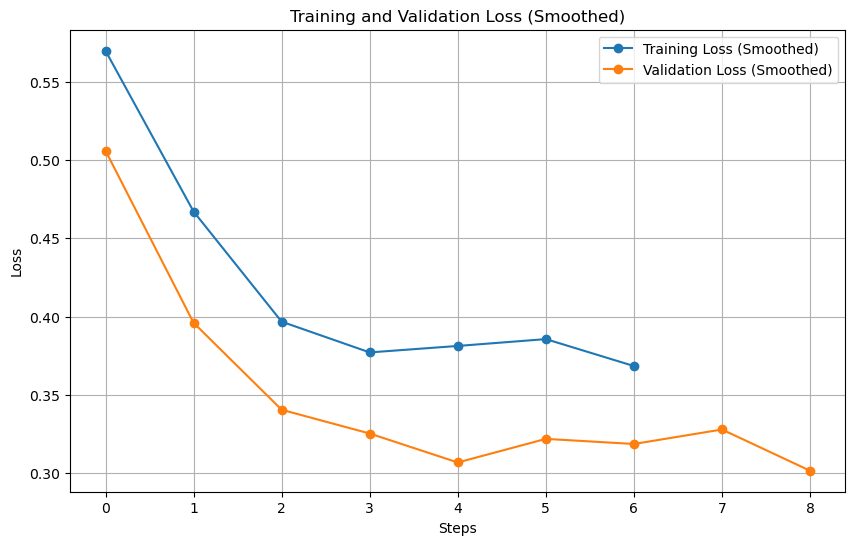

Early stopping triggered after 2 evaluations.


In [9]:
# Initialize Tokenizer and tokenize validation set
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
validation_ds = convert_and_tokenize(df_val, tokenizer)

metrics = []
for size, train_df in nested_splits.items():
    print(f"Training with {size} of data...")
    train_ds = convert_and_tokenize(train_df, tokenizer)

    # Calculate total training steps for the callback
    total_steps = len(train_ds) // 8  # Assuming batch size of 8

    # Train and collecft metrics
    _, split_metrics = train_model(train_ds, validation_ds, total_steps, device)
    split_metrics["split_size"] = size
    metrics.append(split_metrics)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../data/baseline_metrics.csv", index=False)

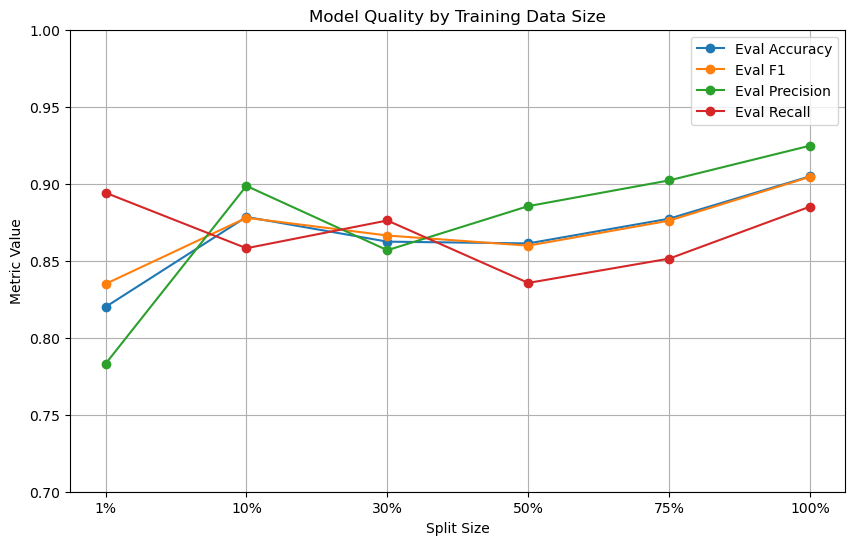

In [17]:
# plot_metrics(metrics_df, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

The plot shows how evaluation metrics (accuracy, F1, precision, and recall) evolve as the training dataset size increases:

1. **1% Split**:
   - Metrics are relatively lower due to limited data for learning meaningful patterns.
   - Recall is the highest, indicating the model is identifying more true positives but at the expense of some false positives

2. **10% Split**:
   - Significant improvement in precision accuracy and F1 score.
   - The model benefits from the increased training data, achieving better balance between precision and recall.

3. **30% Split**:
   - Dip in precision while other metrics remain pretty steady. This could indicate slight overfitting or under-optimization in this split.

4. **50% to 100% Splits**:
   - Metrics consistently improve with more data.
   - Recall, precision, F1 score and accuracy stabilize, with recall showing the most significant gains as the model learns to generalize better.

**General Observations**:
- Adding more data helps the model learn more robust patterns, leading to steady improvements across all metrics.
- Precision, accuracy and F1 score clearly trend upward, indicating a good balance in classification performance.
- The gap between metrics narrows with larger splits, suggesting better overall generalization.

## Text Embeddings

To represent texts numerically, we use **sentence embeddings** generated by the `all-MiniLM-L6-v2` model from the Sentence-Transformers library. These embeddings capture the semantic meaning of entire sentences as high-dimensional vectors, enabling us to quantify similarities between texts. By focusing on the validation and test sets, we ensure an unbiased evaluation of how well embeddings generalize to unseen data.

To assess embedding quality, we calculate **cosine similarity**, which measures the semantic closeness between vectors. For example, we use a reference sentence ("it 's slow -- very , very slow .") and calculate its similarity with other sentences in the dataset. The top-5 most similar sentences are retrieved, showcasing the model's ability to group semantically related content.

This process helps us understand how well embeddings capture sentence meaning, which is crucial for downstream tasks like weak labeling and retrieval.

In [4]:
# Define labeled and unlabeled datasets
labeled_sentences = df_val["sentence"].tolist()     # Validation set sentences
labeled_labels = df_val["label"].tolist()           # Validation set labels

unlabeled_sentences = df_test["sentence"].tolist()  # Test set sentences
ground_truth_labels = df_test["label"].tolist()     # Test set ground truth labels (for evaluation)

In [5]:
# Combine labeled and unlabeled data for embedding
sentences = labeled_sentences + unlabeled_sentences

# Generate embeddings with specifies model
model_name = "all-MiniLM-L6-v2"
embeddings = generate_embeddings(sentences, model_name, device)

reference_index = 4
print_most_similar_sentences(embeddings, sentences, reference_index)

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: it 's slow -- very , very slow . 
Similarity: 0.5328, Sentence: too slow , too long and too little happens . 
Similarity: 0.5008, Sentence: showtime is closer to slowtime .
Similarity: 0.4842, Sentence: i found it slow , drab , and bordering on melodramatic .
Similarity: 0.4804, Sentence: ... too slow , too boring , and occasionally annoying .


**Observations**:
- The most similar sentences share thematic elements like "slow", "boring", "too long" and more negative sentiments.

- This approach demonstrates how embeddings capture semantic similarity, enabling us to retrieve meaningful sentences for weak labeling or analysis later on.

Reducing dimensionality with t-SNE...


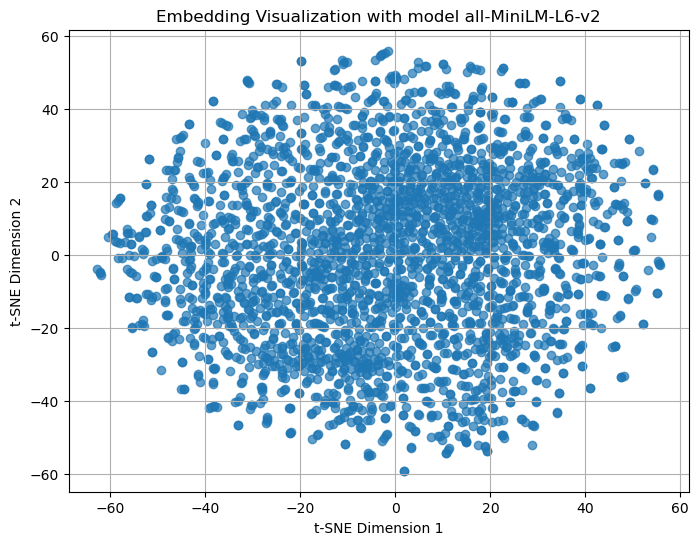

In [6]:
visualize_embeddings(embeddings, title=f"Embedding Visualization with model {model_name}")

The plot visualizes the high-dimensional sentence embeddings reduced to two dimensions using t-SNE. Each point represents a sentence, with its position reflecting its relationship to other sentences in terms of semantic similarity.

**Observations**:
- The points are spread out uniformly, with no distinctly visible clusters. This suggests that the embeddings capture a broad range of semantic meanings rather than clearly defined groups.

In [7]:
get_min_max_distance(embeddings, sentences)

Sentence with the furthest distance to any other sentence:
'scooby dooby doo / and shaggy too / you both look and sound great . '

Sentence closest to the most others (minimum average distance):
'a pleasant enough romance with intellectual underpinnings , the kind of movie that entertains even as it turns maddeningly predictable . '


Here we can see the sentences that are the closest and furthest from the other sentence embeddings.

## Weak Labeling

Weak labeling assigns pseudo-labels to unlabeled data using predefined rules or heuristics. For `df_test`, which contains only `-1` labels (unlabeled), we implemented techniques to assign meaningful labels and make the dataset usable for evaluation.

#### **Techniques for Weak Labeling**
1. **Majority Vote**: Assign the most common label among the top-k most similar sentences.
2. **Weighted Voting**: Assign labels based on similarity-weighted votes from the top-k similar sentences.
3. **Centroid-Based Labeling**: Use precomputed class centroids to assign labels based on the nearest centroid in the embedding space.

#### **Comparison and Optimization**
- **Evaluation**: The techniques are compared using metrics such as accuracy, precision, recall, and F1-score to determine the best method.
- **Optimization**:
  - **Class Centroids**: Precomputing centroids reduces the need for pairwise similarity calculations.
  - **Locality-Sensitive Hashing (LSH)**: Speeds up the retrieval of nearest neighbors for large datasets.

In [13]:
# Step 1: Split data into labeled (validation) and unlabeled (test)
labeled_sentences = df_val["sentence"].tolist()
labels_labeled = np.array(df_val["label"])  # Ground truth for validation set

unlabeled_sentences = df_test["sentence"].tolist()

# Step 2: Generate embeddings for labeled and unlabeled data
embeddings_labeled = generate_embeddings(labeled_sentences)
embeddings_unlabeled = generate_embeddings(unlabeled_sentences)

# Step 3: Evaluate and compare techniques on the validation set
results, techniques = evaluate_and_compare_techniques(
    embeddings_labeled,
    labels_labeled,
    embeddings_unlabeled,
    labels_labeled,
    embeddings_labeled, # Reuse embeddings_labeled for validation
    k=5
)

# Display evaluation results
print("Comparison of Weak Labeling Techniques:")
for technique, metrics in results.items():
    print(f"\n{technique}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    print("-"*15)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Comparison of Weak Labeling Techniques:

Majority Vote:
Accuracy: 0.8234
Precision: 0.7959
Recall: 0.8784
F1: 0.8351
---------------

Weighted Vote:
Accuracy: 0.9243
Precision: 0.9021
Recall: 0.9550
F1: 0.9278
---------------

Centroid-Based:
Accuracy: 0.7959
Precision: 0.8023
Recall: 0.7950
F1: 0.7986
---------------


The results indicate the following:

1. **Majority Vote**: Achieves decent performance, with a balance between precision and recall, resulting in an F1 score of **0.8351**.

2. **Weighted Vote**: Outperforms other techniques with the highest F1 score (**0.9278**) due to its ability to assign labels based on similarity-weighted votes, balancing high precision (**0.9021**) and recall (**0.9550**).

3. **Centroid-Based**: Performs the worst overall, with an F1 score of **0.7986**, likely due to its reliance on fixed centroids, which may not capture complex semantic relationships as effectively.

**Conclusion**: The Weighted Vote technique will be applied to the test set, as it clearly achieved the highest scores.

In [16]:
# Step 4: Apply the best technique to the test set
best_technique = max(results, key=lambda x: results[x]["f1"])  # Select technique with best F1
print(f"Applying best technique ({best_technique}) to the test set...")

test_weak_labels = apply_best_technique_to_test(
    embeddings_labeled, labels_labeled, embeddings_unlabeled, best_technique, k=5
)

# Add weak labels to the test set and save to csv
df_test["label"] = test_weak_labels
df_test.drop(columns=["weak_label"], inplace=True)
df_test.to_csv("../data/test_weakly_labeled.csv", index=False)

Applying best technique (Weighted Vote) to the test set...


## Model training with additional weak labels

Hard labels refer to definitive, manually annotated, or ground-truth labels. They are considered highly accurate and are the gold standard for supervised learning. For example:

- In our dataset, the labels in the validation set (df_val) are hard labels because they were manually assigned and are accurate.
- Weak labels, on the other hand, are pseudo-labels generated by heuristic methods (e.g., embedding similarity), which may contain some noise.

We will extend the baseline training code to incorporate both hard labels (from the labeled data) and weak labels (from the test dataset with pseudo-labels). This will involve:

1. Combining the hierarchically nested training splits with the weakly labeled test data.
2. Training and evaluating the model for each split size.
3. Comparing the results to the baseline metrics.

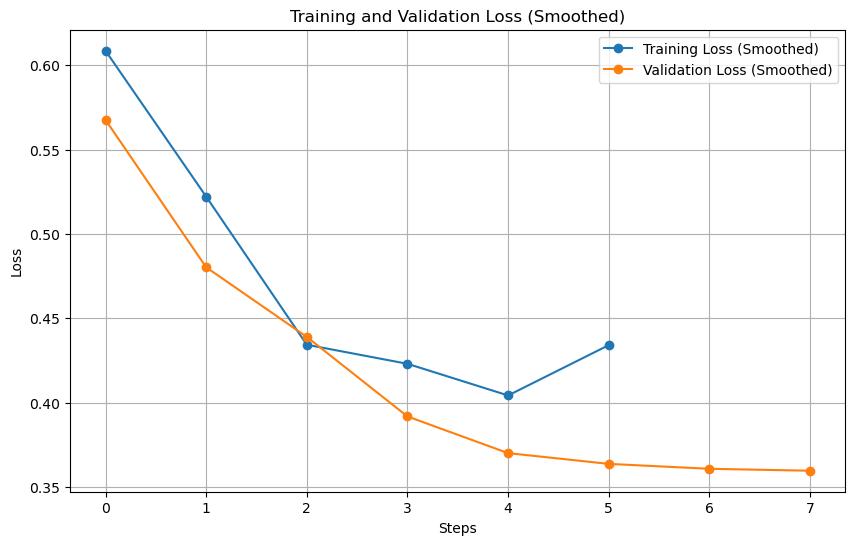

Progress: 200/7672 | Elapsed Time: 0h 8min | Estimated Time Remaining: 5h 36min
Training with weak labels complete. Metrics:
   train_loss  eval_loss  eval_accuracy  eval_precision  eval_recall  \
0    0.453109   0.424192       0.825688        0.774436     0.927928   
1    0.395947   0.379220       0.847477        0.843267     0.860360   
2    0.368518   0.328944       0.872706        0.877551     0.871622   
3    0.493641   0.463296       0.847477        0.793951     0.945946   
4    0.382612   0.406529       0.842890        0.913747     0.763514   
5    0.345596   0.354333       0.862385        0.871560     0.855856   

    eval_f1 split_size  
0  0.844262         1%  
1  0.851728        10%  
2  0.874576        30%  
3  0.863309        50%  
4  0.831902        75%  
5  0.863636       100%  


In [17]:
metrics_weak = []

for size, df_train in nested_splits.items():
    print(f"Training with {size} of data...")
    
    # Combine training data with weakly labeled test data
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Tokenize combined training set
    train_ds = convert_and_tokenize(combined_df, tokenizer)

    # Calculate total training steps for callback
    total_steps = len(train_ds) // 8  # Assuming batch size of 8

    # Train and collect metrics
    _, split_metrics = train_model(train_ds, validation_ds, total_steps, device)
    split_metrics["split_size"] = size
    metrics_weak.append(split_metrics)

# Convert metrics to DataFrame
metrics_weak_df = pd.DataFrame(metrics_weak)
metrics_weak_df.to_csv("../data/weak_label_metrics.csv", index=False)

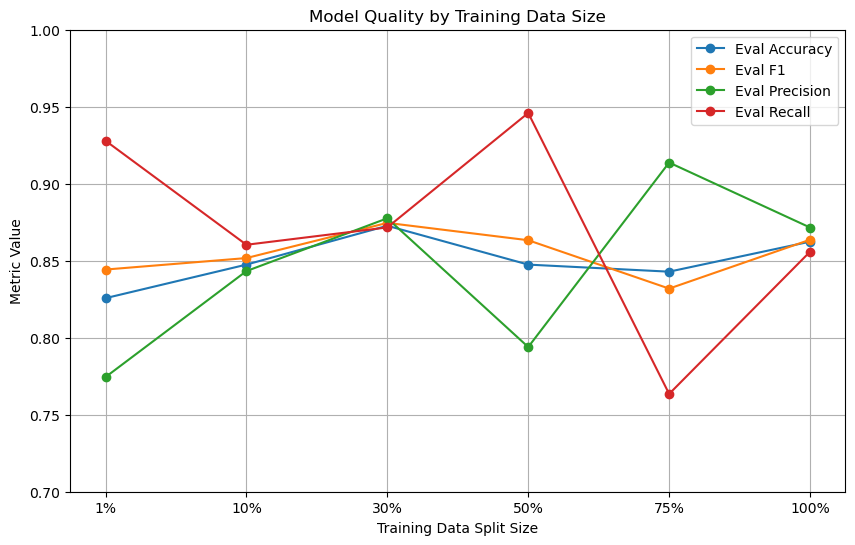

In [18]:
plot_metrics(metrics_weak_df, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

## Model comparison

1. Compare Baseline and Weak Label Models
2. Evaluate Weak Labels Directly
3. Decide on the Best Approach